In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'png2x'
plt.rcParams['lines.marker'] = '^'
plt.rcParams['lines.markersize'] = 4
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['font.size'] = 10

In [2]:
# Number of time steps
nt = 12

# Number of testing data
num_data = 200

# Number of branches
num_branches = 186

# Power flow limit
file_path = f'../../data/IEEE_Case118/branch_params/PF_max_category1.csv'
PF_max_category1 = pd.read_csv(file_path, header=None, index_col=None).to_numpy().astype(bool).flatten()
file_path = f'../../data/IEEE_Case118/branch_params/PF_max_category2.csv'
PF_max_category2 = pd.read_csv(file_path, header=None, index_col=None).to_numpy().astype(bool).flatten()
file_path = f'../../data/IEEE_Case118/branch_params/PF_max_category3.csv'
PF_max_category3 = pd.read_csv(file_path, header=None, index_col=None).to_numpy().astype(bool).flatten()

# Set line flow threshold
epsilon = 0.85

PF_max1 = 200
PF_max2 = 300
PF_max3 = 500

PF_threshold = np.zeros((num_branches, nt))
PF_threshold[PF_max_category1, :] = epsilon * PF_max1
PF_threshold[PF_max_category2, :] = epsilon * PF_max2
PF_threshold[PF_max_category3, :] = epsilon * PF_max3

In [3]:
PTDF = pd.read_csv('../../data/IEEE_Case118/PTDF/PTDF_matrix.csv', header=None, index_col=None)

In [5]:
for i in range(num_data):
    PB_true = pd.read_csv(f'../../res/IEEE_Case118/model_evaluation/PB/true_corr/true_corr_{i+1}.csv', header=None, index_col=None)
    PF_true = PTDF@PB_true
    PF_true.to_csv(f'../../res/IEEE_Case118/model_evaluation/PF/true_corr/true_corr_{i+1}.csv', index=None, header=None)

    PB_pred = pd.read_csv(f'../../res/IEEE_Case118/model_evaluation/PB/pred_corr/pred_corr_{i+1}.csv', header=None, index_col=None)
    PF_pred = PTDF@PB_pred
    PF_pred.to_csv(f'../../res/IEEE_Case118/model_evaluation/PF/pred_corr/pred_corr_{i+1}.csv', index=None, header=None)

In [7]:
# Matrix to store results
PF_res_true = np.zeros((num_data, num_branches, nt))
PF_res_pred = np.zeros((num_data, num_branches, nt))

# Read PF file
for i in range(num_data):
    # Ground truth
    file_path = f'../../res/IEEE_Case118/model_evaluation/PF/true_corr/true_corr_{i+1}.csv'
    PF_true = pd.read_csv(file_path, header=None, index_col=None).to_numpy()
    res = (np.abs(PF_true) >= PF_threshold)
    PF_res_true[i] = res.copy()

    # Prediction
    file_path = f'../../res/IEEE_Case118/model_evaluation/PF/pred_corr/pred_corr_{i+1}.csv'
    PF_pred = pd.read_csv(file_path, header=None, index_col=None).to_numpy()
    res = (np.abs(PF_pred) >= PF_threshold)
    PF_res_pred[i] = res.copy()

PF_res_true = PF_res_true.astype(float)
PF_res_pred = PF_res_pred.astype(float)

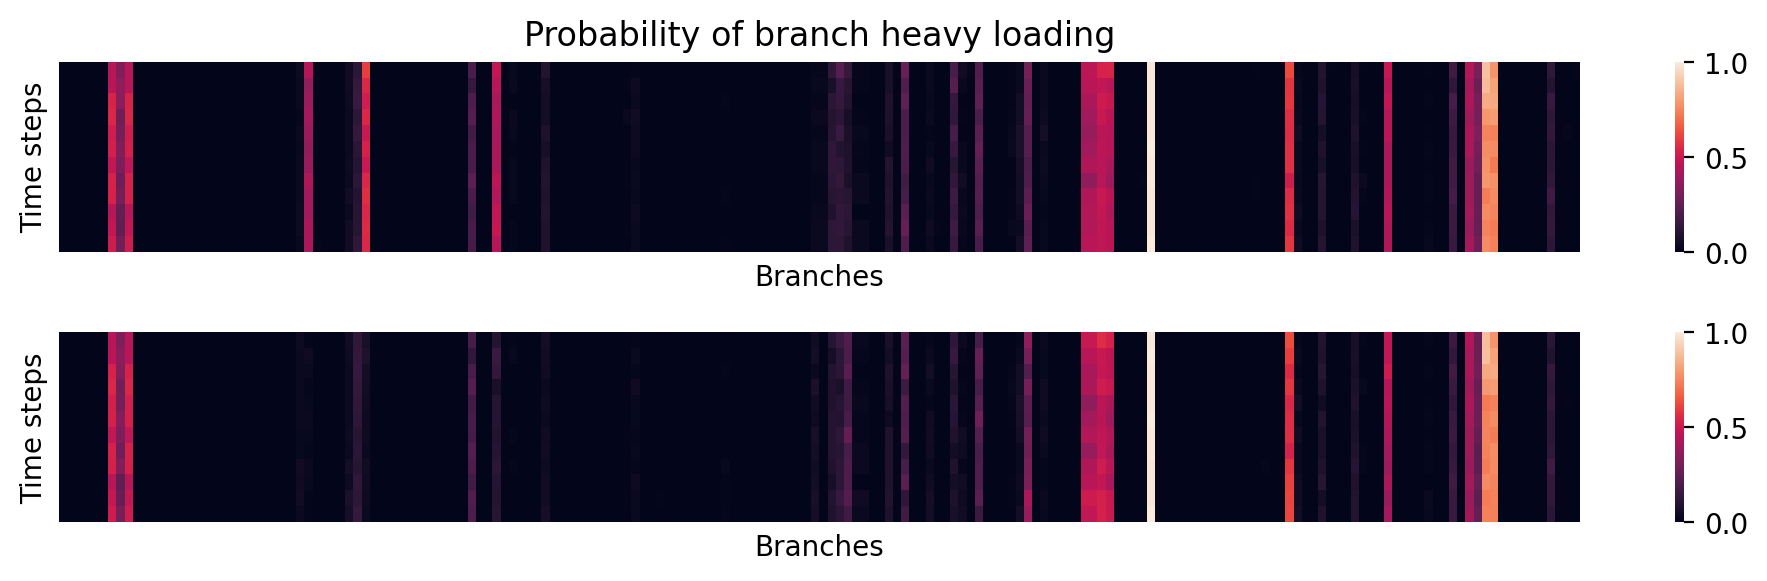

In [8]:
# Probability of heavying loading
prob_true = PF_res_true.mean(axis=0)
prob_pred = PF_res_pred.mean(axis=0)

fig = plt.figure(figsize=(10, 3))
ax1 = fig.add_subplot(211)
sns.heatmap(prob_true.T, 
            ax=ax1,
            vmin=0,
            vmax=1,
            xticklabels=[],
            yticklabels=[])
ax1.set_title('Probability of branch heavy loading')
ax1.set_xlabel('Branches')
ax1.set_ylabel('Time steps')

ax2 = fig.add_subplot(212)
sns.heatmap(prob_pred.T, 
            ax=ax2,
            vmin=0,
            vmax=1,
            xticklabels=[],
            yticklabels=[])
ax2.set_xlabel('Branches')
ax2.set_ylabel('Time steps')

plt.tight_layout()
plt.show()
plt.close('all')

In [9]:
# Get sorted branch index according to mean probability of ground truth
sorted_idx = np.argsort(prob_true.T.mean(axis=0))

# Select six important branches
num_top_branches = 9
top_branch_idx = sorted_idx[-num_top_branches:]

# Sort top branch index
# top_branch_idx = np.sort(top_branch_idx)

top_branch_idx

array([128, 127,   8,   6,  37, 150, 175, 174, 133], dtype=int64)

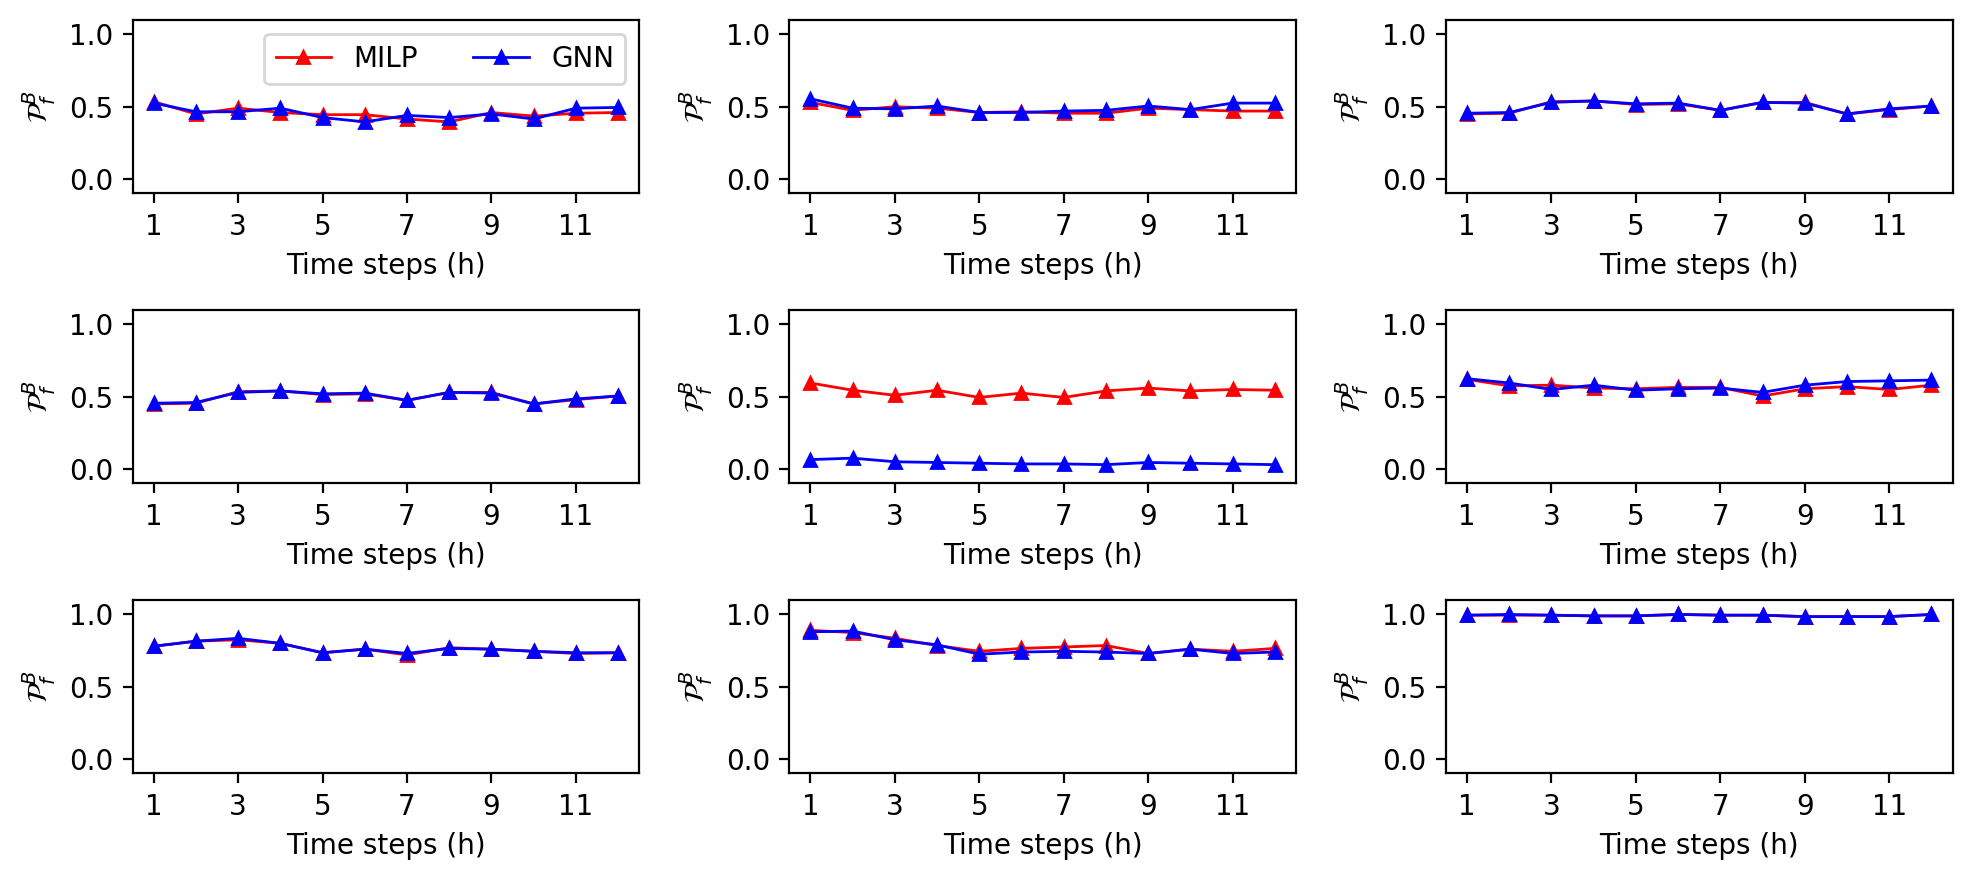

In [10]:
# Plot probability for individual branch
x = np.arange(1, 13)
fig = plt.figure(figsize=(10, 4.5))
ax1 = fig.add_subplot(3, 3, 1)
ax1.plot(x, prob_true[top_branch_idx[0], :], color='red', label='MILP')
ax1.plot(x, prob_pred[top_branch_idx[0], :], color='blue', label='GNN')
ax1.set_xlim((0.5, 12.5))
ax1.set_xticks(np.arange(1, 13, 2))
ax1.set_ylim((-0.1, 1.1))
ax1.set_xlabel('Time steps (h)')
ax1.set_ylabel('$\mathcal{P}^B_f$')
ax1.legend(ncols=2)

for i in range(1, num_top_branches):
    ax = fig.add_subplot(3, 3, i+1)
    ax.plot(x, prob_true[top_branch_idx[i], :], color='red')
    ax.plot(x, prob_pred[top_branch_idx[i], :], color='blue')
    ax.set_xlim((0.5, 12.5))
    ax.set_xticks(np.arange(1, 13, 2))
    ax.set_ylim((-0.1, 1.1))
    ax.set_xlabel('Time steps (h)')
    ax.set_ylabel('$\mathcal{P}^B_f$')

plt.tight_layout()
plt.show()
plt.close('all')